In [2]:
import pandas as pd
import numpy as np

In [43]:
df = pd.read_csv("final_features.csv")
df.head()

,case_id,malignancy,original_shape_LeastAxisLength_0,original_shape_LeastAxisLength_1,original_shape_LeastAxisLength_2,original_shape_LeastAxisLength_3,original_shape_LeastAxisLength_4,original_shape_LeastAxisLength_5,original_shape_LeastAxisLength_6,original_shape_LeastAxisLength_7,...,volume_22,volume_23,volume_24,volume_25,volume_26,volume_27,volume_28,volume_29,volume_30,volume_31
0,LIDC-IDRI-0001_12_84,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,LIDC-IDRI-0001_12_85,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,LIDC-IDRI-0001_12_86,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,LIDC-IDRI-0001_12_87,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,LIDC-IDRI-0002_13_88,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

def avg_and_std(scores):
    return np.mean(scores), np.std(scores)

# Function for k-fold cross-validation with optional PCA
def k_fold_cv(model, df, metric_funcs, n_splits=5, pca_components=None):
    X = df.iloc[:, 2:].values  # Features
    y = df.iloc[:, 1].values   # Target

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = {metric_func.__name__: [] for metric_func in metric_funcs}

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Apply PCA if specified
        if pca_components is not None:
            pca = PCA(n_components=pca_components)
            X_train = pca.fit_transform(X_train)
            X_test = pca.transform(X_test)
        
        # Train model
        model.fit(X_train, y_train)
        
        # Get predictions
        y_pred = model.predict_proba(X_test)[:, 1]
        
        # Calculate and store each metric
        for metric_func in metric_funcs:
            score = metric_func(y_test, y_pred)
            scores[metric_func.__name__].append(score)
    
    return scores

In [45]:
best_auc = 0
best_params = {}

# Parameter combination test
for crit in ["gini", "entropy", "log_loss"]:
    for n_est in range(25, 201, 25):
        for m_depth in range(5, 106, 10):
            for m_samples_leaf in range(5, 26, 5):
                params = {
                    'n_estimators': n_est,
                    'max_depth': m_depth,
                    'min_samples_leaf': m_samples_leaf,
                    'criterion': crit
                }
                
                # Initialize model with current parameters
                rf_model = RandomForestClassifier(**params)
                
                # Perform cross-validation and get AUC scores
                score = k_fold_cv(model=rf_model, df=df, metric_funcs=[roc_auc_score], pca_components=100)
                avg_auc, std_auc = avg_and_std(np.array(score["roc_auc_score"]))
                
                # Update best parameters if new best AUC is found
                if avg_auc > best_auc:
                    best_auc = avg_auc
                    best_params = params
                    print("New best parameter combination found!")
                    for parameter, value in best_params.items():
                        print(f"\t{parameter}: {value}")
                    print(f"Best Average AUC: {best_auc * 100:.6f}%\n")
                else:
                    print("Parameter combination tested:")
                    for parameter, value in params.items():
                        print(f"\t{parameter}: {value}")
                    print(f"Average AUC: {avg_auc * 100:.6f}%\n")

New best parameter combination found!
	n_estimators: 25
	max_depth: 5
	min_samples_leaf: 5
	criterion: gini
Best Average AUC: 89.586028%

New best parameter combination found!
	n_estimators: 25
	max_depth: 5
	min_samples_leaf: 10
	criterion: gini
Best Average AUC: 89.740910%

New best parameter combination found!
	n_estimators: 25
	max_depth: 5
	min_samples_leaf: 15
	criterion: gini
Best Average AUC: 89.962982%

New best parameter combination found!
	n_estimators: 25
	max_depth: 5
	min_samples_leaf: 20
	criterion: gini
Best Average AUC: 90.001800%

Parameter combination tested:
	n_estimators: 25
	max_depth: 5
	min_samples_leaf: 25
	criterion: gini
Average AUC: 89.287585%

New best parameter combination found!
	n_estimators: 25
	max_depth: 15
	min_samples_leaf: 5
	criterion: gini
Best Average AUC: 90.556605%

New best parameter combination found!
	n_estimators: 25
	max_depth: 15
	min_samples_leaf: 10
	criterion: gini
Best Average AUC: 90.599706%

Parameter combination tested:
	n_estimat

#melhor combinaçao

In [46]:
# Display final best parameters and AUC
print("Best parameter combination:")
for parameter, value in best_params.items():
    print(f"\t{parameter}: {value}")
print(f"Best Average AUC: {best_auc * 100:.2f}%")

Best parameter combination:
	n_estimators: 100
	max_depth: 35
	min_samples_leaf: 5
	criterion: log_loss
Best Average AUC: 91.63%


## Testar resultado final

Test Accuracy:  0.8628526645768025
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       770
           1       0.85      0.80      0.82       506

    accuracy                           0.86      1276
   macro avg       0.86      0.85      0.86      1276
weighted avg       0.86      0.86      0.86      1276



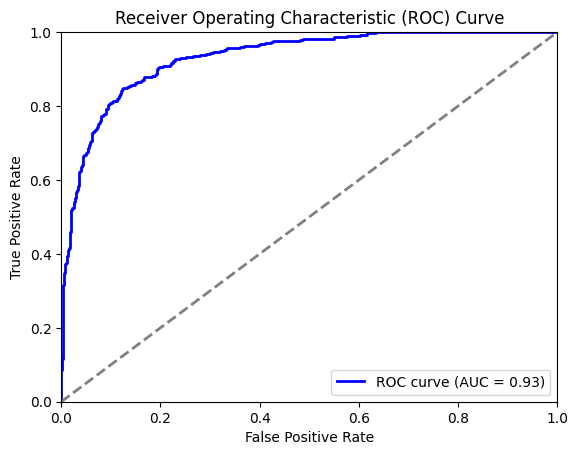

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

data = pd.read_csv('final_features.csv')
y = data["malignancy"]
X = data.drop(columns=['malignancy','case_id'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=666)

# melhor modelo
model = RandomForestClassifier(n_estimators=100, max_depth=35, min_samples_leaf=5, criterion='log_loss')
model.fit(X_train,y_train)

# classificacao de novos dados
y_pred = model.predict(X_test)

# Evaluate the model on the test data
print("Test Accuracy: ", accuracy_score(y_test, y_pred))
print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred))


# Step 12: Calculate the ROC curve
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Step 13: Calculate the AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)

# Step 14: Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()